# Engineering Calculations Workshop

**Comprehensive Practice Notebook**

This notebook combines all Python essentials into realistic engineering workflows. Work through each section to practice syntax, data structures, control flow, and functions in context.

---

## Setup

Import necessary libraries and set up plotting.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

%matplotlib inline

print("✓ Environment ready")

✓ Environment ready


---
## Project 1: Beam Analysis Library

Build a set of functions for analyzing simply supported beams.

### Step 1: Define Material Properties

In [2]:
# Material database (dict of tuples)
MATERIALS = {
    "steel": ("Steel", 7850, 200e9, 250e6),  # name, density kg/m3, E Pa, yield MPa
    "concrete_25": ("Concrete C25", 2400, 30e9, 25e6),
    "concrete_40": ("Concrete C40", 2400, 35e9, 40e6),
    "timber": ("Timber", 600, 12e9, 35e6),
}

# Display materials
for key, (name, density, modulus, strength) in MATERIALS.items():
    print(f"{key:15} | {name:15} | E = {modulus/1e9:.0f} GPa | fy = {strength/1e6:.0f} MPa")

steel           | Steel           | E = 200 GPa | fy = 250 MPa
concrete_25     | Concrete C25    | E = 30 GPa | fy = 25 MPa
concrete_40     | Concrete C40    | E = 35 GPa | fy = 40 MPa
timber          | Timber          | E = 12 GPa | fy = 35 MPa


### Step 2: Create Beam Analysis Functions

In [3]:
def calculate_reactions(load_kn_m: float, span_m: float) -> tuple[float, float]:
    """
    Calculate support reactions for simply supported beam with uniform load.
    
    Args:
        load_kn_m: Uniform distributed load (kN/m)
        span_m: Span length (m)
    
    Returns:
        Tuple of (R_left, R_right) in kN
    """
    total_load = load_kn_m * span_m
    reaction = total_load / 2
    return reaction, reaction


def calculate_max_moment(load_kn_m: float, span_m: float) -> float:
    """
    Calculate maximum bending moment.
    
    Returns:
        Max moment in kN·m
    """
    return (load_kn_m * span_m ** 2) / 8


def calculate_max_shear(load_kn_m: float, span_m: float) -> float:
    """
    Calculate maximum shear force.
    
    Returns:
        Max shear in kN
    """
    r_left, _ = calculate_reactions(load_kn_m, span_m)
    return r_left


def calculate_max_deflection(
    load_kn_m: float,
    span_m: float,
    elastic_modulus_pa: float,
    moment_of_inertia_m4: float
) -> float:
    """
    Calculate maximum deflection for simply supported beam.
    
    Formula: δ_max = (5 × w × L⁴) / (384 × E × I)
    
    Returns:
        Max deflection in mm
    """
    load_n_m = load_kn_m * 1000  # Convert to N/m
    deflection_m = (5 * load_n_m * span_m ** 4) / (384 * elastic_modulus_pa * moment_of_inertia_m4)
    return deflection_m * 1000  # Convert to mm


print("✓ Beam analysis functions defined")

✓ Beam analysis functions defined


### Step 3: Section Property Calculator

In [4]:
def calculate_rectangular_section_properties(width_mm: float, depth_mm: float) -> dict:
    """
    Calculate section properties for rectangular cross-section.
    
    Returns:
        Dictionary with area, I, and S
    """
    # Convert to meters for calculation
    width_m = width_mm / 1000
    depth_m = depth_mm / 1000
    
    area_m2 = width_m * depth_m
    moment_of_inertia_m4 = (width_m * depth_m ** 3) / 12
    section_modulus_m3 = (width_m * depth_m ** 2) / 6
    
    return {
        "width_mm": width_mm,
        "depth_mm": depth_mm,
        "area_m2": area_m2,
        "I_m4": moment_of_inertia_m4,
        "S_m3": section_modulus_m3,
    }

# Test
section = calculate_rectangular_section_properties(200, 400)
print(f"Section: {section['width_mm']} × {section['depth_mm']} mm")
print(f"I = {section['I_m4']:.6e} m⁴")
print(f"S = {section['S_m3']:.6e} m³")

Section: 200 × 400 mm
I = 1.066667e-03 m⁴
S = 5.333333e-03 m³


### Step 4: Complete Beam Analysis

In [5]:
def analyze_beam(
    beam_id: str,
    load_kn_m: float,
    span_m: float,
    width_mm: float,
    depth_mm: float,
    material_key: str
) -> dict:
    """
    Complete beam analysis.
    
    Returns:
        Analysis results dictionary
    """
    # Get material properties
    mat_name, density, elastic_modulus, strength = MATERIALS[material_key]
    
    # Section properties
    section = calculate_rectangular_section_properties(width_mm, depth_mm)
    
    # Analysis
    r_left, r_right = calculate_reactions(load_kn_m, span_m)
    max_moment = calculate_max_moment(load_kn_m, span_m)
    max_shear = calculate_max_shear(load_kn_m, span_m)
    max_deflection = calculate_max_deflection(
        load_kn_m, span_m, elastic_modulus, section['I_m4']
    )
    
    # Stress check
    max_stress_pa = max_moment * 1e6 / section['S_m3']  # Convert moment to N·m
    stress_utilization = max_stress_pa / strength
    
    # Deflection check (L/250)
    allowable_deflection_mm = (span_m * 1000) / 250
    deflection_utilization = max_deflection / allowable_deflection_mm
    
    return {
        "id": beam_id,
        "material": mat_name,
        "section": f"{width_mm}×{depth_mm}mm",
        "span_m": span_m,
        "load_kn_m": load_kn_m,
        "reactions_kn": (r_left, r_right),
        "max_moment_kn_m": max_moment,
        "max_shear_kn": max_shear,
        "max_stress_mpa": max_stress_pa / 1e6,
        "stress_utilization": stress_utilization,
        "max_deflection_mm": max_deflection,
        "deflection_utilization": deflection_utilization,
        "adequate": stress_utilization <= 1.0 and deflection_utilization <= 1.0
    }


# Run analysis
result = analyze_beam(
    beam_id="B1",
    load_kn_m=15.0,
    span_m=6.0,
    width_mm=200,
    depth_mm=400,
    material_key="concrete_25"
)

# Print report
print(f""" 
BEAM ANALYSIS REPORT
{'=' * 60}
Beam ID:          {result['id']}
Material:         {result['material']}
Section:          {result['section']}
Span:             {result['span_m']:.1f} m
Load:             {result['load_kn_m']:.1f} kN/m

RESULTS
{'-' * 60}
Reactions:        {result['reactions_kn'][0]:.1f} kN (each support)
Max Moment:       {result['max_moment_kn_m']:.1f} kN·m
Max Shear:        {result['max_shear_kn']:.1f} kN

CHECKS
{'-' * 60}
Stress:           {result['max_stress_mpa']:.2f} MPa ({result['stress_utilization']:.1%})
Deflection:       {result['max_deflection_mm']:.2f} mm ({result['deflection_utilization']:.1%})

STATUS:           {'✓ ADEQUATE' if result['adequate'] else '✗ INADEQUATE'}
""")

 
BEAM ANALYSIS REPORT
Beam ID:          B1
Material:         Concrete C25
Section:          200×400mm
Span:             6.0 m
Load:             15.0 kN/m

RESULTS
------------------------------------------------------------
Reactions:        45.0 kN (each support)
Max Moment:       67.5 kN·m
Max Shear:        45.0 kN

CHECKS
------------------------------------------------------------
Stress:           12656.25 MPa (50625.0%)
Deflection:       7.91 mm (33.0%)

STATUS:           ✗ INADEQUATE



### Step 5: Batch Analysis with Iteration

In [6]:
# Define multiple beams
beam_definitions = [
    {"id": "B1", "load": 12.0, "span": 5.0, "width": 200, "depth": 350, "material": "concrete_25"},
    {"id": "B2", "load": 18.0, "span": 7.0, "width": 200, "depth": 450, "material": "concrete_40"},
    {"id": "B3", "load": 10.0, "span": 6.0, "width": 150, "depth": 300, "material": "concrete_25"},
]

# Analyze all beams
results = []
for beam_def in beam_definitions:
    result = analyze_beam(
        beam_id=beam_def["id"],
        load_kn_m=beam_def["load"],
        span_m=beam_def["span"],
        width_mm=beam_def["width"],
        depth_mm=beam_def["depth"],
        material_key=beam_def["material"]
    )
    results.append(result)

# Summary table
print("\nBEAM ANALYSIS SUMMARY")
print("=" * 80)
print(f"{'ID':5} {'Section':12} {'Moment':>12} {'Stress Util':>12} {'Defl Util':>12} {'Status':>10}")
print("-" * 80)

for r in results:
    status = "✓ OK" if r['adequate'] else "✗ FAIL"
    print(
        f"{r['id']:5} "
        f"{r['section']:12} "
        f"{r['max_moment_kn_m']:10.1f} kN·m "
        f"{r['stress_utilization']:10.1%} "
        f"{r['deflection_utilization']:10.1%} "
        f"{status:>10}"
    )

# Find critical beam
critical = max(results, key=lambda x: max(x['stress_utilization'], x['deflection_utilization']))
print(f"\nCritical beam: {critical['id']} (max utilization)")


BEAM ANALYSIS SUMMARY
ID    Section            Moment  Stress Util    Defl Util     Status
--------------------------------------------------------------------------------
B1    200×350mm          37.5 kN·m   36734.7%      22.8%     ✗ FAIL
B2    200×450mm         110.2 kN·m   40833.3%      37.8%     ✗ FAIL
B3    150×300mm          45.0 kN·m   80000.0%      69.4%     ✗ FAIL

Critical beam: B3 (max utilization)


### Step 6: Visualize Results

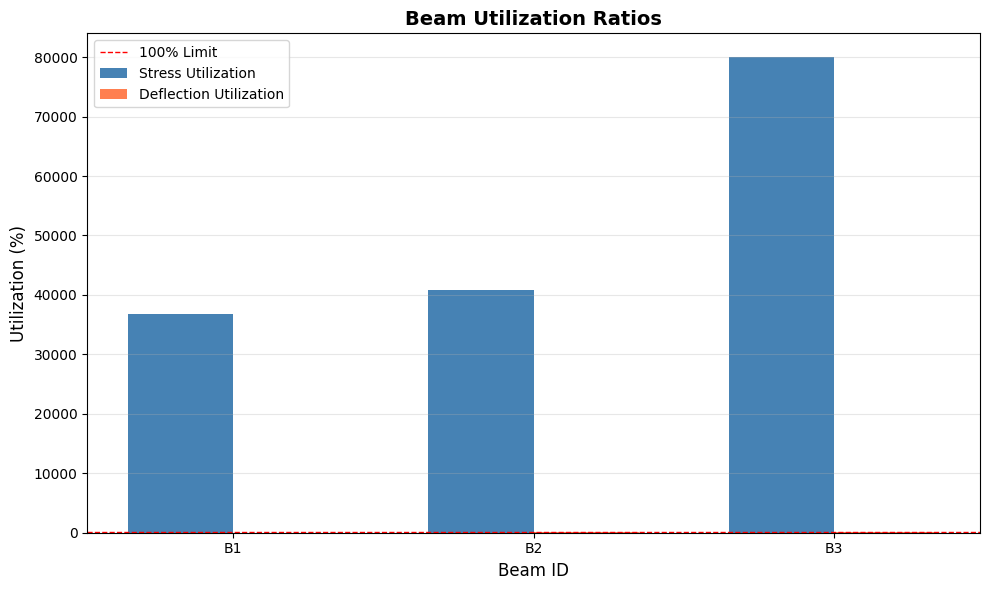

In [7]:
# Extract data for plotting
beam_ids = [r['id'] for r in results]
stress_utils = [r['stress_utilization'] * 100 for r in results]
defl_utils = [r['deflection_utilization'] * 100 for r in results]

# Create bar chart
x = np.arange(len(beam_ids))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, stress_utils, width, label='Stress Utilization', color='steelblue')
bars2 = ax.bar(x + width/2, defl_utils, width, label='Deflection Utilization', color='coral')

# Add reference line at 100%
ax.axhline(y=100, color='red', linestyle='--', linewidth=1, label='100% Limit')

# Formatting
ax.set_xlabel('Beam ID', fontsize=12)
ax.set_ylabel('Utilization (%)', fontsize=12)
ax.set_title('Beam Utilization Ratios', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(beam_ids)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
## Project 2: Iterative Design

Find the minimum beam depth to satisfy both strength and deflection criteria.

In [8]:
def find_minimum_depth(
    load_kn_m: float,
    span_m: float,
    width_mm: float,
    material_key: str,
    starting_depth_mm: int = 300,
    increment_mm: int = 50,
    max_iterations: int = 30
) -> dict:
    """
    Iterate to find minimum adequate beam depth.
    
    Returns:
        Dictionary with solution and iteration history
    """
    depth_mm = starting_depth_mm
    iteration = 0
    history = []
    
    while iteration < max_iterations:
        result = analyze_beam(
            beam_id=f"Test_{iteration}",
            load_kn_m=load_kn_m,
            span_m=span_m,
            width_mm=width_mm,
            depth_mm=depth_mm,
            material_key=material_key
        )
        
        history.append({
            "iteration": iteration,
            "depth_mm": depth_mm,
            "stress_util": result['stress_utilization'],
            "defl_util": result['deflection_utilization'],
            "adequate": result['adequate']
        })
        
        if result['adequate']:
            return {
                "success": True,
                "iterations": iteration + 1,
                "depth_mm": depth_mm,
                "result": result,
                "history": history
            }
        
        depth_mm += increment_mm
        iteration += 1
    
    return {
        "success": False,
        "iterations": iteration,
        "history": history
    }

# Run iterative design
solution = find_minimum_depth(
    load_kn_m=20.0,
    span_m=8.0,
    width_mm=250,
    material_key="concrete_40"
)

if solution['success']:
    print(f"✓ Solution found after {solution['iterations']} iterations")
    print(f"Minimum depth: {solution['depth_mm']} mm")
    print(f"Stress utilization: {solution['result']['stress_utilization']:.1%}")
    print(f"Deflection utilization: {solution['result']['deflection_utilization']:.1%}")
else:
    print(f"✗ No solution found within {solution['iterations']} iterations")

# Show iteration history
print("\nIteration History:")
for h in solution['history']:
    status = "✓" if h['adequate'] else "✗"
    print(f"  {status} Iter {h['iteration']}: {h['depth_mm']}mm → Stress {h['stress_util']:.1%}, Defl {h['defl_util']:.1%}")

✗ No solution found within 30 iterations

Iteration History:
  ✗ Iter 0: 300mm → Stress 106666.7%, Defl 169.3%
  ✗ Iter 1: 350mm → Stress 78367.3%, Defl 106.6%
  ✗ Iter 2: 400mm → Stress 60000.0%, Defl 71.4%
  ✗ Iter 3: 450mm → Stress 47407.4%, Defl 50.2%
  ✗ Iter 4: 500mm → Stress 38400.0%, Defl 36.6%
  ✗ Iter 5: 550mm → Stress 31735.5%, Defl 27.5%
  ✗ Iter 6: 600mm → Stress 26666.7%, Defl 21.2%
  ✗ Iter 7: 650mm → Stress 22721.9%, Defl 16.6%
  ✗ Iter 8: 700mm → Stress 19591.8%, Defl 13.3%
  ✗ Iter 9: 750mm → Stress 17066.7%, Defl 10.8%
  ✗ Iter 10: 800mm → Stress 15000.0%, Defl 8.9%
  ✗ Iter 11: 850mm → Stress 13287.2%, Defl 7.4%
  ✗ Iter 12: 900mm → Stress 11851.9%, Defl 6.3%
  ✗ Iter 13: 950mm → Stress 10637.1%, Defl 5.3%
  ✗ Iter 14: 1000mm → Stress 9600.0%, Defl 4.6%
  ✗ Iter 15: 1050mm → Stress 8707.5%, Defl 3.9%
  ✗ Iter 16: 1100mm → Stress 7933.9%, Defl 3.4%
  ✗ Iter 17: 1150mm → Stress 7259.0%, Defl 3.0%
  ✗ Iter 18: 1200mm → Stress 6666.7%, Defl 2.6%
  ✗ Iter 19: 1250mm → St

---
## Project 3: Load Combinations

Generate and evaluate all load combinations.

In [9]:
# Load cases (unfactored)
load_cases = {
    "Dead": 8.0,   # kN/m
    "Live": 6.0,   # kN/m
    "Wind": 3.0,   # kN/m
}

# Load combination rules (LRFD)
combinations = [
    {"name": "1.4D", "factors": {"Dead": 1.4}},
    {"name": "1.2D + 1.6L", "factors": {"Dead": 1.2, "Live": 1.6}},
    {"name": "1.2D + 1.0L + 1.0W", "factors": {"Dead": 1.2, "Live": 1.0, "Wind": 1.0}},
    {"name": "1.2D + 1.6W + 0.5L", "factors": {"Dead": 1.2, "Wind": 1.6, "Live": 0.5}},
]

# Calculate factored loads
factored_loads = []
for combo in combinations:
    total = sum(
        load_cases[case] * combo["factors"].get(case, 0.0)
        for case in load_cases
    )
    factored_loads.append({
        "combination": combo["name"],
        "factored_load_kn_m": total
    })

# Display
print("LOAD COMBINATIONS")
print("=" * 50)
for fl in factored_loads:
    print(f"{fl['combination']:25} → {fl['factored_load_kn_m']:6.2f} kN/m")

# Find governing
governing = max(factored_loads, key=lambda x: x['factored_load_kn_m'])
print(f"\nGoverning: {governing['combination']} = {governing['factored_load_kn_m']:.2f} kN/m")

LOAD COMBINATIONS
1.4D                      →  11.20 kN/m
1.2D + 1.6L               →  19.20 kN/m
1.2D + 1.0L + 1.0W        →  18.60 kN/m
1.2D + 1.6W + 0.5L        →  17.40 kN/m

Governing: 1.2D + 1.6L = 19.20 kN/m


---
## Challenge: Full Project Workflow

Combine everything into a complete analysis pipeline.

In [10]:
def run_project_analysis(project_data: dict) -> dict:
    """
    Complete project analysis workflow.
    
    Expected project_data structure:
    {
        "project_name": str,
        "beams": list of beam definitions
    }
    """
    results = []
    failures = []
    
    for beam_def in project_data["beams"]:
        try:
            result = analyze_beam(
                beam_id=beam_def["id"],
                load_kn_m=beam_def["load"],
                span_m=beam_def["span"],
                width_mm=beam_def["width"],
                depth_mm=beam_def["depth"],
                material_key=beam_def["material"]
            )
            results.append(result)
            
            if not result['adequate']:
                failures.append(result['id'])
        
        except KeyError as e:
            print(f"⚠ Error analyzing beam {beam_def.get('id', 'unknown')}: Missing key {e}")
        except Exception as e:
            print(f"⚠ Unexpected error: {e}")
    
    # Generate summary
    total_beams = len(results)
    adequate_beams = sum(1 for r in results if r['adequate'])
    
    return {
        "project_name": project_data["project_name"],
        "total_beams": total_beams,
        "adequate_beams": adequate_beams,
        "failed_beams": failures,
        "results": results,
        "status": "PASS" if len(failures) == 0 else "FAIL"
    }

# Define project
project = {
    "project_name": "Office Building - Level 2",
    "beams": [
        {"id": "B101", "load": 15.0, "span": 6.0, "width": 200, "depth": 400, "material": "concrete_25"},
        {"id": "B102", "load": 18.0, "span": 7.5, "width": 250, "depth": 450, "material": "concrete_40"},
        {"id": "B103", "load": 12.0, "span": 5.5, "width": 200, "depth": 350, "material": "concrete_25"},
        {"id": "B104", "load": 20.0, "span": 8.0, "width": 200, "depth": 400, "material": "concrete_40"},
    ]
}

# Run analysis
project_result = run_project_analysis(project)

# Print summary
print(f"""
PROJECT ANALYSIS SUMMARY
{'=' * 70}
Project:          {project_result['project_name']}
Total Beams:      {project_result['total_beams']}
Adequate:         {project_result['adequate_beams']}
Failed:           {len(project_result['failed_beams'])}
Status:           {project_result['status']}
""")

if project_result['failed_beams']:
    print(f"Failed beams: {', '.join(project_result['failed_beams'])}")


PROJECT ANALYSIS SUMMARY
Project:          Office Building - Level 2
Total Beams:      4
Adequate:         0
Failed:           4
Status:           FAIL

Failed beams: B101, B102, B103, B104


---
## Conclusion

This notebook demonstrates how Python's core features—variables, data structures, control flow, and functions—combine to solve real engineering problems.

### Key Patterns You Practiced

1. **Functions** - Modular, testable calculation units
2. **Dictionaries** - Modeling complex engineering objects
3. **Lists** - Collections of beams, loads, results
4. **Loops** - Batch processing and iteration
5. **Conditionals** - Design checks and decision logic
6. **Exception handling** - Robust error management

### Next Steps

- Add more material types
- Implement different loading patterns (point loads, triangular)
- Create plotting functions for moment/shear diagrams
- Export results to CSV or PDF reports
- Build a simple command-line interface

Keep building. The best way to learn is to solve problems that matter to you.